
### Tutorial Objective          :  Get  a score 0.69 or more for this [Kaggle challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard) 


## Steps

1. Read Zhiding Yu's & Cha Zhang's paper [1] [Image based Static Facial Expression Recognition with Multiple Deep Network Learning](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/icmi2015_ChaZhang.pdf)
    - **It is very important to understand this paper**
    - We are going to implement the NN model and methods in this paper
2. Checkout this repo - [https://github.com/LamUong/FacialExpressionRecognition](https://github.com/LamUong/FacialExpressionRecognition)
    - it has lot of helper functions to read data
    - It has Simple Average Ensemble method
    - This code will save us a lot of time
3. Exploratory data analysis

4. Build a NN model based on Zhiding Yu's paper [1]
    - Use the basic CNN model given in the paper as a reference design
    - Try to improve the model by 
            - adding more layers
            - using different optimiser
            - using different cost function etc.
    - Use randomized peturbation for training(Data Augmentation)
    - Get as high testing accuracy as possible
    
5. Test with Private Leader Board data
6. Analyse the results of the stand alone model
    - print confusion matrix
    - plot validation/training accuracy/loss
7. Build Different ensemble models (using Randomly perturbed input) to further increase accuracy
    - Simple Average Ensembling
    - NN based Ensembling
8. Plot and Compare the results of different approaches
9. Choose the one with highest tesing accuracy
    - and pray it beats Kaggle scores ![Image](http://globe-views.com/dcim/dreams/smile/smile-01.jpg)


[1] Image based Static Facial Expression Recognition with Multiple Deep Network Learning


### Mre Details can be found here              :  https://github.com/LamUong/FacialExpressionRecognition

### Current Achieved Accuracy for the [Kaggle challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard) :  0.7035


## Some observaions
- test and validation accuracy seems to be very close (so the test accuracy will be almost same as validation accuracy)

**Notice** <br/>
Permission to make digital or hard copies of all or part of this work for personal or classroom use is granted without fee provided that copies are not made or distributed for profit or commercial advantage and that copies bear this notice and the full citation on the first page. Copyrights for components of this work owned by others than ACM must be honored. Abstracting with credit is permitted. To copy otherwise, or republish, to post on servers or to redistribute to lists, requires prior specific permission and/or a fee.

<br/> Request permissions from Permissions@acm.org.
<br/> EmotiW’15, November 9, 2015, Seattle, WA, USA.
<br/> 2015 ACM. ISBN 978-1-4503-3983-4/15/11 ...$15.00.
<br/> DOI: http://dx.doi.org/10.1145/2823327.2823341.

#### Some observaions

#### the test accuracy and private leader board accuracy are very close


In [1]:
from __future__ import print_function

import cv2
import PIL
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.layers import AveragePooling2D
from keras.optimizers import Adadelta ,SGD 
from keras.utils import np_utils
#from keras.regularizers import l2, activity_l2
from keras.regularizers import l2, l1
from keras.layers import deserialize as layer_from_config
import numpy as np
import _pickle as cPickle
import numpy
import cv2
import scipy
import csv
import dataprocessing
from numpy import array
from keras.models import load_model

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 4. Build the model (on Zhiding Yu's paper)

#### Custom cost function


In [3]:
import keras.backend as K

def categorical_crossentropy_svm(y_true, y_pred):
    alpha = 0.6
        
    ce_loss = K.categorical_crossentropy(y_true, y_pred)
    
    rmse_loss = K.sqrt(K.mean(K.square((y_pred - y_true)*(1 - y_true)), axis=-1))
    
    return (ce_loss + rmse_loss)

# We have alredy done the training, so here we just load the Model

### Load and preprocess the train and validation data

In [4]:
def get_train_val_data():
    
    X_train, y_train, X_val, y_val  = dataprocessing.load_data()
    
    for i in range(len(X_train)):
        X_train[i] = (array(X_train[i])).reshape(48, 48, 1)
        
    X_train= array(X_train)
    
    for i in range(len(X_val)):
        X_val[i] = (array(X_val[i])).reshape(48, 48, 1)
        
    X_val= array(X_val)
    
    y_train = array(y_train)
    y_val   = array(y_val)
    
    # Convert 1-dimensional class arrays to 10-dimensional class matrices
    Y_train = np_utils.to_categorical(y_train, 7)
    Y_val = np_utils.to_categorical(y_val, 7)
    
    return X_train, Y_train, X_val, Y_val

In [7]:
X_train, Y_train, X_val, Y_val = get_train_val_data()

In [8]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(32181, 48, 48, 1) (32181, 7) (3589, 48, 48, 1) (3589, 7)


### 5. Test with Private Leader Board data

In [12]:
def get_private_test_data():
    
    X_private_test, y_private_test  = dataprocessing.load_test_data()
    
    for i in range(len(X_private_test)):
        X_private_test[i] = (array(X_private_test[i])).reshape(48, 48, 1)
    
    X_private_test= array(X_private_test)
    Y_private_test = np_utils.to_categorical(y_private_test, 7)
    
    return X_private_test, Y_private_test

In [13]:
X_private_test, Y_private_test = get_private_test_data()

In [14]:
print(X_private_test.shape, Y_private_test.shape)

(3589, 48, 48, 1) (3589, 7)


### 5. 1 Load the trained model

In [15]:
new_model = load_model("FaceExp_Reco_tr_08.best.hdf5",custom_objects={'categorical_crossentropy_svm': categorical_crossentropy_svm})



### 5.2 Verfiy the performace on train and validation data

In [16]:
score = new_model.evaluate(X_train, Y_train, verbose=1)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

32181/32181 [==============================] - 75s 2ms/step
Training loss: 0.41371478178647747
Training accuracy: 0.86796556975168


In [17]:
score = new_model.evaluate(X_val, Y_val, verbose=1)
print('Public Leader Board Test loss:', score[0])
print('Public Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 2s 510us/step
Public Leader Board Test loss: 1.1828097103697637
Public Leader Board Test accuracy: 0.6960156032487057


### 5.2 Test with Private Leader Board data

In [18]:
#score = new_model.evaluate(X_private_test, Y_private_test, verbose=1)
score = new_model.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 2s 511us/step
Private Leader Board Test loss: 1.1828097103697637
Private Leader Board Test accuracy: 0.6960156032487057


### 6.  Analyse the results of the stand alone model

In [26]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline  



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm) #to print in text if needed

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 6.1  print confusion matrix - check how the model performed on various classes (TEST)

In [27]:
Y_private_pred = new_model.predict_proba(X_private_test)


In [28]:
y_true = []
y_pred = []

for row in Y_private_test:
    a = numpy.argmax(row) #return the indices of the maximum values along the axis
    y_true.append(a)
    
for row in Y_private_pred:
    a = numpy.argmax(row) #return the indices of the maximum values along the axis
    y_pred.append(a)

Normalized confusion matrix


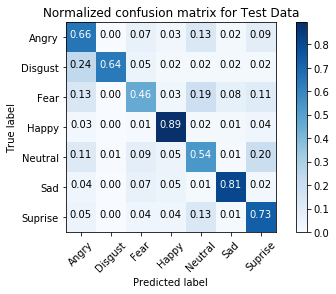

In [29]:
cnf_matrix     = confusion_matrix(y_true, y_pred)
class_names    = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Test Data')

### 6.3  print confusion matrix - check how the model performed on various classes (TRAIN)

In [30]:
Y_train_pred = new_model.predict_proba(X_train)

In [31]:
y_true = []
y_pred = []

for row in Y_train:
    a = numpy.argmax(row) #return the indices of the maximum values along the axis
    y_true.append(a)
    
for row in Y_train_pred:
    a = numpy.argmax(row) #return tY_train_predhe indices of the maximum values along the axis
    y_pred.append(a)

Normalized confusion matrix


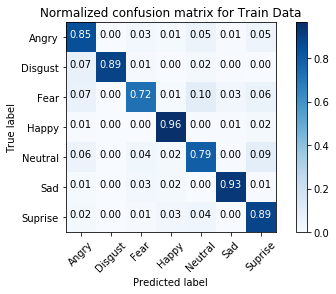

In [32]:
cnf_matrix     = confusion_matrix(y_true, y_pred)
class_names    = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Train Data')

### 6.3  Observations

- Here we can see on what classes the model performed well and bad
- Fear and Neutral classes are performing badly on Test Data

### 7. Build Different ensemble models (using Randomly perturbed input) to further  increase accuracy

### 7.1 Simple Average Ensembling

In [35]:
private_set_x, private_set_y = dataprocessing.load_test_data()

In [36]:
def predict_prob(number,test_set_x,model):
    data_p = []
    for data in test_set_x:
        if number ==0:
            data_p.append(dataprocessing.Flip(data))
        elif number ==1:
            data_p.append(dataprocessing.Roated15Left(data))
        elif number ==2:
            data_p.append(dataprocessing.Roated15Right(data))
        elif number ==3:
            data_p.append(dataprocessing.shiftedUp20(data))
        elif number ==4:
            data_p.append(dataprocessing.shiftedDown20(data))
        elif number ==5:
            data_p.append(dataprocessing.shiftedLeft20(data))
        elif number ==6:
            data_p.append(dataprocessing.shiftedRight20(data))
        elif number ==7:
            data_p.append(data)
    
    #Covert the data to Numpy format
    for i in range(len(data_p)):
        data_p[i] = (array(data_p[i])).reshape(48, 48, 1)
        
    X_private_test= array(data_p)
            
    proba = model.predict_proba(X_private_test)
    return proba

In [37]:
model = new_model

proba0 = predict_prob(0, private_set_x, model)
proba1 = predict_prob(1, private_set_x, model)
proba2 = predict_prob(2, private_set_x, model)
proba3 = predict_prob(3, private_set_x, model)
proba4 = predict_prob(4, private_set_x, model)
proba5 = predict_prob(5, private_set_x, model)
proba6 = predict_prob(6, private_set_x, model)
proba7 = predict_prob(7, private_set_x, model)

In [38]:
Y_SA_Ense_pred = []
for row in zip(proba0,proba1,proba2,proba3,proba4,proba5,proba6,proba7):
    a = numpy.argmax(np.array(row).mean(axis=0)) #return the indices of the maximum values along the axis
    Y_SA_Ense_pred.append(a)

In [39]:
Y_SA_Ense_pred = np.array(Y_SA_Ense_pred)
private_set_y  = np.array(private_set_y)

### Calculate how many correct predictions we got

In [40]:
count_correct = np.sum(Y_SA_Ense_pred == private_set_y)

In [52]:
print("Accuracy of Simple Average Ensembling on Private Leader Board Data:"+str((float(count_correct)/len(Y_SA_Ense_pred))))

Accuracy of Simple Average Ensembling on Private Leader Board Data:0.7035385901365283


Normalized confusion matrix


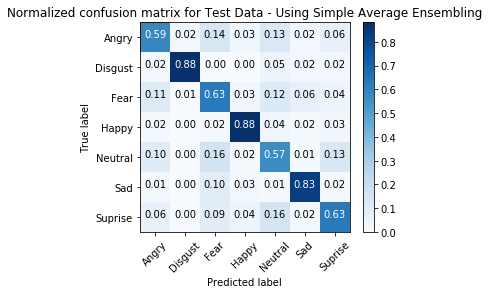

In [53]:
cnf_matrix     = confusion_matrix(Y_SA_Ense_pred, private_set_y)
class_names    = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Test Data - Using Simple Average Ensembling')

### 7.1.1 Simple Average Ensembling - Observations

- Using Simple Average Ensembling, we could  slightly improve the performace of the prediction model
    - from **0.6960** to **0.7035**

### 9.  Choose the one with highest tesing accuracy

### 9.1 Conclusion
- Simple Average Ensembling has an accuracy of 0.7030 which beats the score of 0.69